In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

2024-04-06 16:28:17.595346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 16:28:17.897769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 16:28:17.897809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 16:28:17.944192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 16:28:18.032892: I tensorflow/core/platform/cpu_feature_guar

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=8
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


2024-04-06 16:28:29.477337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:28:29.595256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:28:29.595313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:28:29.597976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:28:29.598029: I external/local_xla/xla/stream_executor

In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [6]:
len(dataset)

524

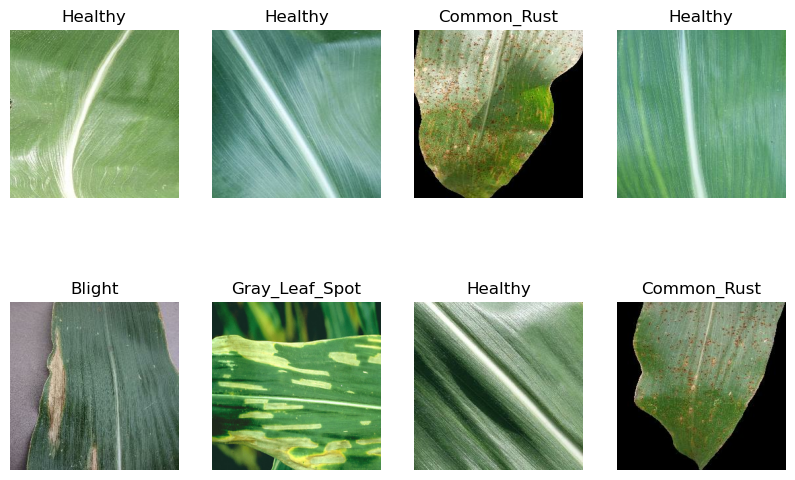

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(8):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def get_dataset_partitions_tf(ds,train_split=.8,val_split=.1,test_split=.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [10]:
len(test_ds)

53

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(.2),
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (8, 127, 127, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (8, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (8, 62, 62, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (8, 60, 60, 64)          

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20


2024-04-06 16:30:29.507035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 388 of 10000
2024-04-06 16:30:33.053940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-04-06 16:30:33.054616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-04-06 16:30:33.157676: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-06 16:30:34.161412: I external/local_xla/xla/service/service.cc:168] XLA service 0x74ace80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 16:30:34.161449: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-04-06 16:30:34.175230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_RE

419/419 [==============================] - 42s 55ms/step - loss: 0.9389 - accuracy: 0.5415 - val_loss: 0.9420 - val_accuracy: 0.4927
Epoch 2/20
419/419 [==============================] - 16s 37ms/step - loss: 0.8709 - accuracy: 0.5672 - val_loss: 0.9341 - val_accuracy: 0.5510
Epoch 3/20
419/419 [==============================] - 14s 34ms/step - loss: 0.8108 - accuracy: 0.6102 - val_loss: 0.9205 - val_accuracy: 0.5680
Epoch 4/20
419/419 [==============================] - 14s 34ms/step - loss: 0.8614 - accuracy: 0.5597 - val_loss: 0.9044 - val_accuracy: 0.5558
Epoch 5/20
419/419 [==============================] - 15s 35ms/step - loss: 0.8541 - accuracy: 0.5645 - val_loss: 0.9146 - val_accuracy: 0.5558
Epoch 6/20
419/419 [==============================] - 14s 34ms/step - loss: 0.8531 - accuracy: 0.5669 - val_loss: 0.9213 - val_accuracy: 0.5558
Epoch 7/20
419/419 [==============================] - 15s 35ms/step - loss: 0.8427 - accuracy: 0.5696 - val_loss: 0.9135 - val_accuracy: 0.5558
Epo

In [20]:
scores = model.evaluate(test_ds)
scores

53/53 [==============================] - 8s 14ms/step - loss: 0.2495 - accuracy: 0.8962


[0.24947874248027802, 0.8962264060974121]

In [21]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 419}

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

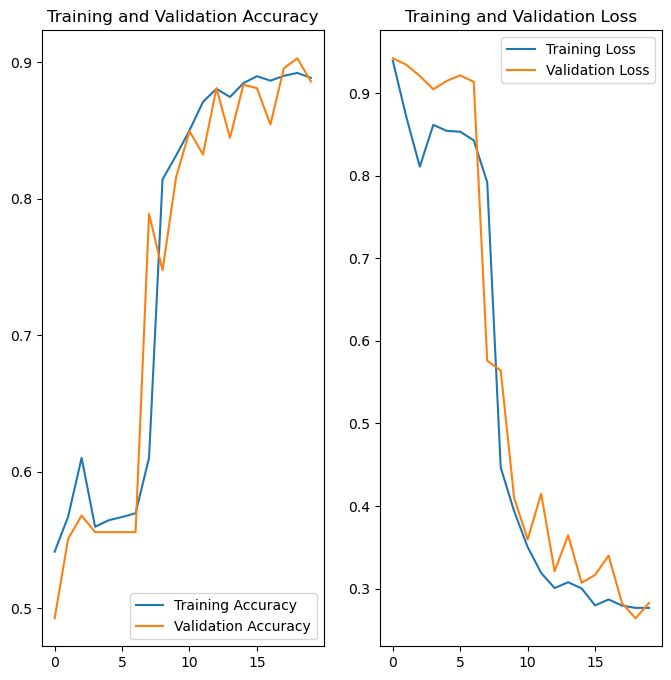

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Blight
1/1 [==============================] - 0s 21ms/step
predicted label: Blight


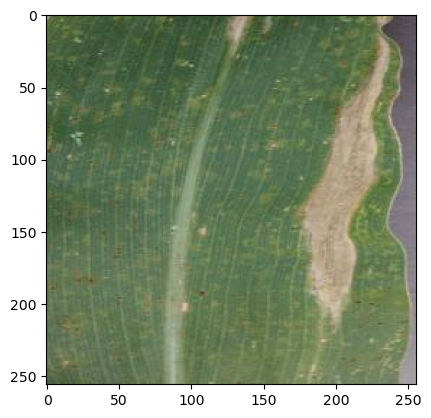

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [28]:
len(test_ds)

53

1/1 [==============================] - 0s 18ms/step


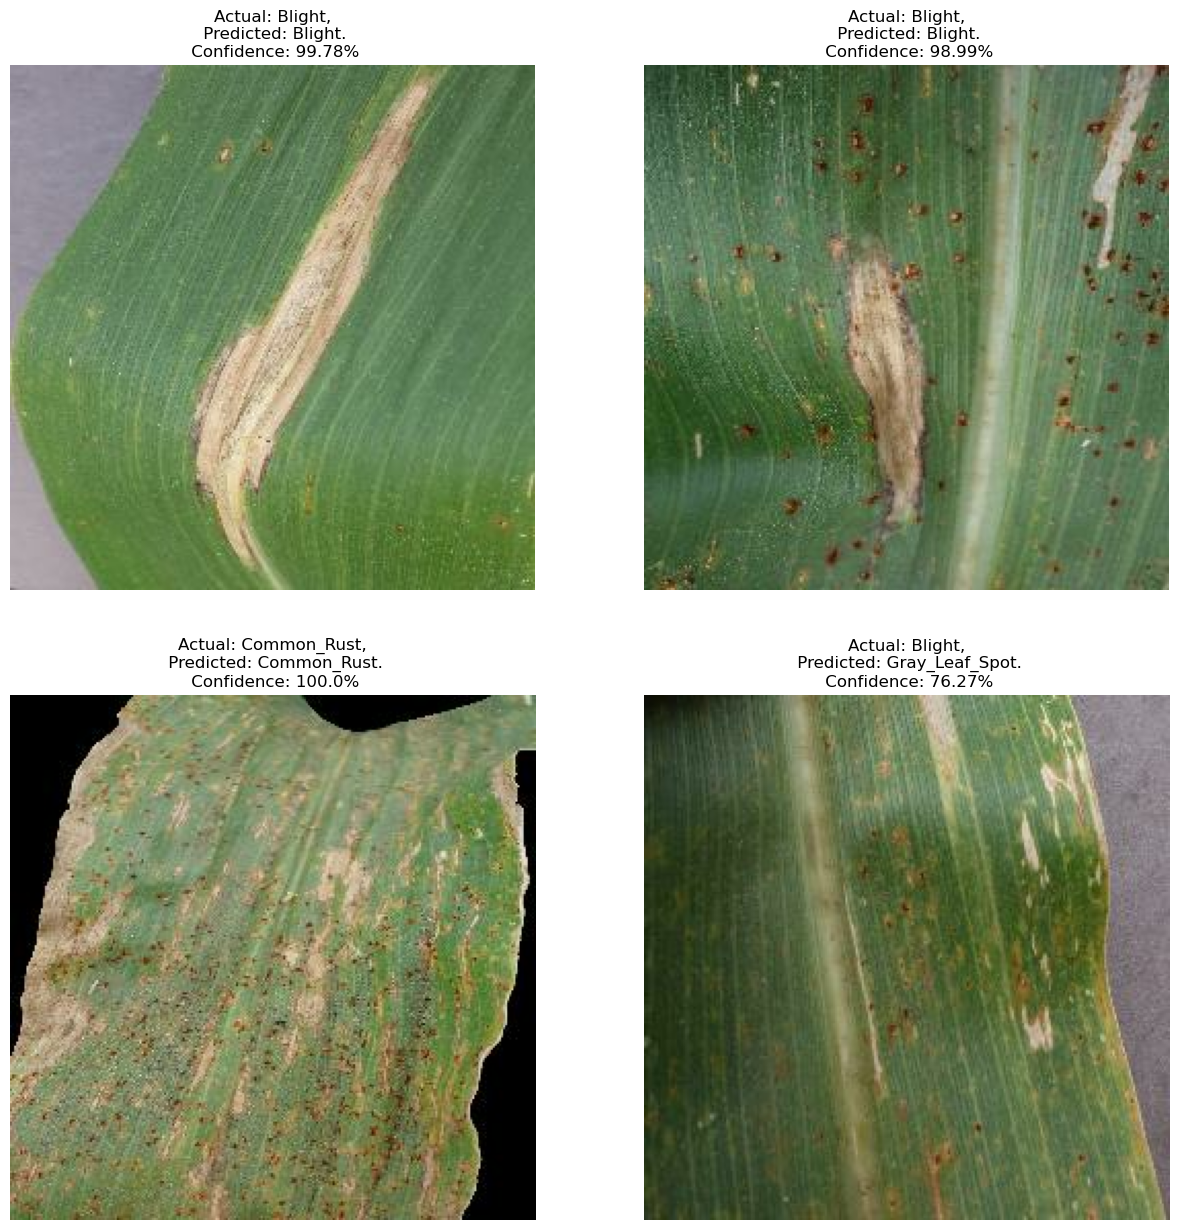

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [30]:
import os
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets


In [31]:
model.save("./corn_model.h5")

/root/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
